In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


## Разбор данных

In [2]:
train_data = pd.read_csv('train.csv', sep = ';').drop(columns = ['id', 'f1', 'f75'])
test_data = pd.read_csv('test.csv', sep = ';').drop(columns = ['id', 'f1', 'f75'])

/tmp/ipykernel_8529/663960677.py:1: DtypeWarning: Columns (1,11,12,29,33,34,35,36,37,38,39,40,75,107,115,119,153) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train.csv', sep = ';').drop(columns = ['id', 'f1', 'f75'])


In [3]:
train_data.head()

,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,...,f283,f284,f285,f286,f287,f288,f289,f290,f291,target
0,37.0,19.0,5.0,16.0,1.0,1984.0,1.0,9.0,2.0,Investment,...,6.0,2.0,0.0,4.0,8.0,0.0,2.0,21.0,5.0,4900000.0
1,53.0,30.0,10.0,12.0,1.0,1983.0,2.0,8.0,3.0,Investment,...,290.0,120.0,24.0,92.0,165.0,1.0,75.0,167.0,13.0,13500000.0
2,38.0,17.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,15.0,4.0,0.0,13.0,28.0,1.0,2.0,82.0,9.0,6100000.0
3,75.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,...,4.0,2.0,0.0,3.0,15.0,1.0,0.0,24.0,4.0,5662500.0
4,35.0,19.0,6.0,12.0,1.0,1971.0,1.0,10.0,3.0,Investment,...,18.0,1.0,0.0,5.0,14.0,0.0,4.0,44.0,5.0,4999000.0


In [4]:
print(train_data.info())
print(train_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24376 entries, 0 to 24375
Columns: 290 entries, f2 to target
dtypes: float64(275), object(15)
memory usage: 53.9+ MB
None
                 f2            f3            f4            f5            f6  \
count  19999.000000  15866.000000  19897.000000  13776.000000  13776.000000   
mean      54.345767     34.645216      7.670302     12.552700      1.835801   
std       44.077600     62.735853      5.320041      6.725911      1.489968   
min        0.000000      0.000000      0.000000      0.000000      1.000000   
25%       38.000000     20.000000      3.000000      9.000000      1.000000   
50%       50.000000     30.000000      7.000000     12.000000      1.000000   
75%       63.000000     43.000000     11.000000     17.000000      2.000000   
max     5326.000000   7478.000000     77.000000    117.000000      6.000000   

                 f7            f8            f9           f10           f13  \
count  1.111000e+04  13776.000000  13

In [5]:
test_data.head()

,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,...,f282,f283,f284,f285,f286,f287,f288,f289,f290,f291
0,41,20.0,9.0,14.0,1.0,1984.0,1.0,8.0,2.0,Investment,...,33,7,4,0,10,15,0,0,40,3
1,58,43.0,2.0,9.0,1.0,1971.0,3.0,6.0,NaN,Investment,...,20,5,3,0,7,25,0,10,56,7
2,35,14.0,4.0,23.0,1.0,2005.0,1.0,9.0,2.0,Investment,...,28,9,3,0,11,23,0,5,77,17
3,33,19.0,3.0,9.0,1.0,1971.0,1.0,6.0,2.0,Investment,...,19,13,8,1,8,13,0,2,46,0
4,53,30.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,45,15,4,0,13,28,1,0,72,5


In [6]:
print(test_data.info())
print(test_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4378 entries, 0 to 4377
Columns: 289 entries, f2 to f291
dtypes: float64(119), int64(155), object(15)
memory usage: 9.7+ MB
None
                f2           f3           f4           f5           f6  \
count  4378.000000  3400.000000  4346.000000  2951.000000  2951.000000   
mean     53.758337    33.777059     7.747354    12.566588     1.825822   
std      21.369484    19.619018     5.348318     6.948641     1.474814   
min       1.000000     0.000000     0.000000     0.000000     1.000000   
25%      39.000000    20.000000     3.000000     9.000000     1.000000   
50%      49.000000    30.000000     7.000000    12.000000     1.000000   
75%      63.000000    42.000000    11.000000    17.000000     2.000000   
max     325.000000   325.000000    41.000000    99.000000     6.000000   

                f7           f8           f9          f10           f13  ...  \
count  2382.000000  2951.000000  2951.000000  2345.000000  4.378000e+03  .

In [7]:
#train_data.isnull().sum().values
#test_data.isnull().sum().values

In [8]:
train_data.dropna(subset=['target'], inplace=True)

In [9]:
train_data.isnull().sum().values

array([   0, 4133,  102, 6223, 6223, 8889, 6223, 6223, 8809,    0,    0,
          0,    0,    0,    0,    0, 4340,    0,    0, 4338,    0,    0,
       9423,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       3262, 3262, 3262, 3262, 3262, 3262, 3262, 3262, 3262, 3262, 3262,
       3262, 3262, 3262, 3262, 3262,    0,    0,    0,   20,   20,    0,
          0,    0,    0,    0,    0,    0,    0,   20,   20,   20,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

Убрали строки, где нету таргета, тк они бесполезны для обучения

Теперь более подробно посмотрим на сами данные, уберём всё что мешает

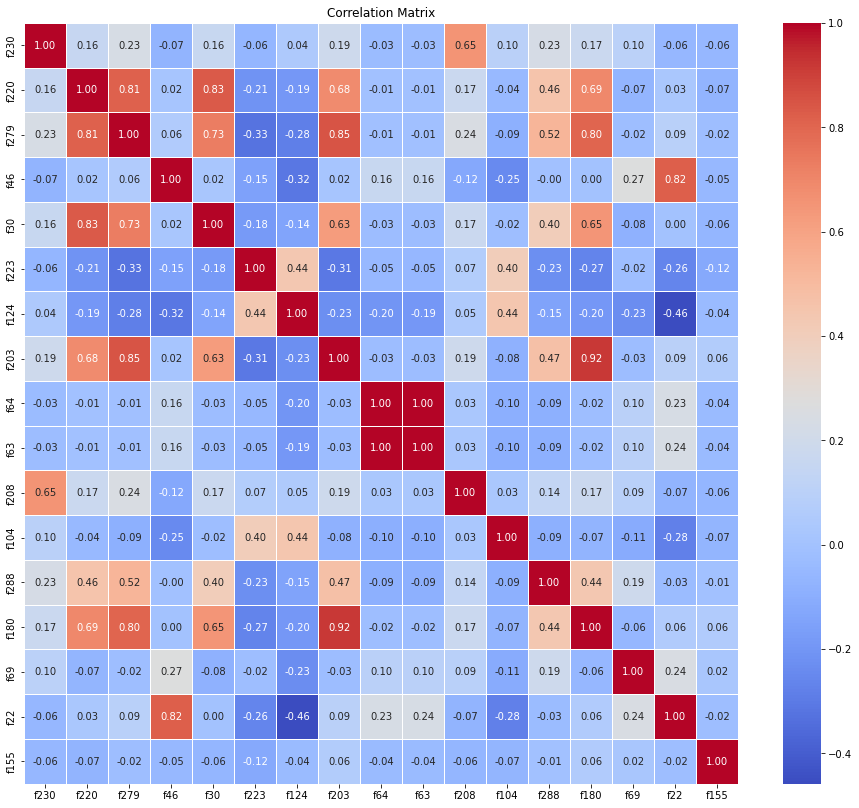

In [10]:
# 20 рандомных фич
random_features = np.random.choice(train_data.columns, size=20, replace=False)
selected_data = train_data[random_features]

# Корреляционная матрица
correlation_matrix = selected_data.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

Высокая корреляция между признаками может указывать на сильную линейную зависимость между ними, поэтому будем убирать дублирующие фичи

In [11]:
correlation_matrix = train_data.corr()

# Найдем верхний треугольник корреляционной матрицы (чтобы избежать повторений)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

# Найдем и удалим индексы столбцов с корреляцией более 0.7 
high_corr_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.69999)]
train_data.drop(high_corr_cols, axis=1, inplace=True)

/tmp/ipykernel_8529/4212460111.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))


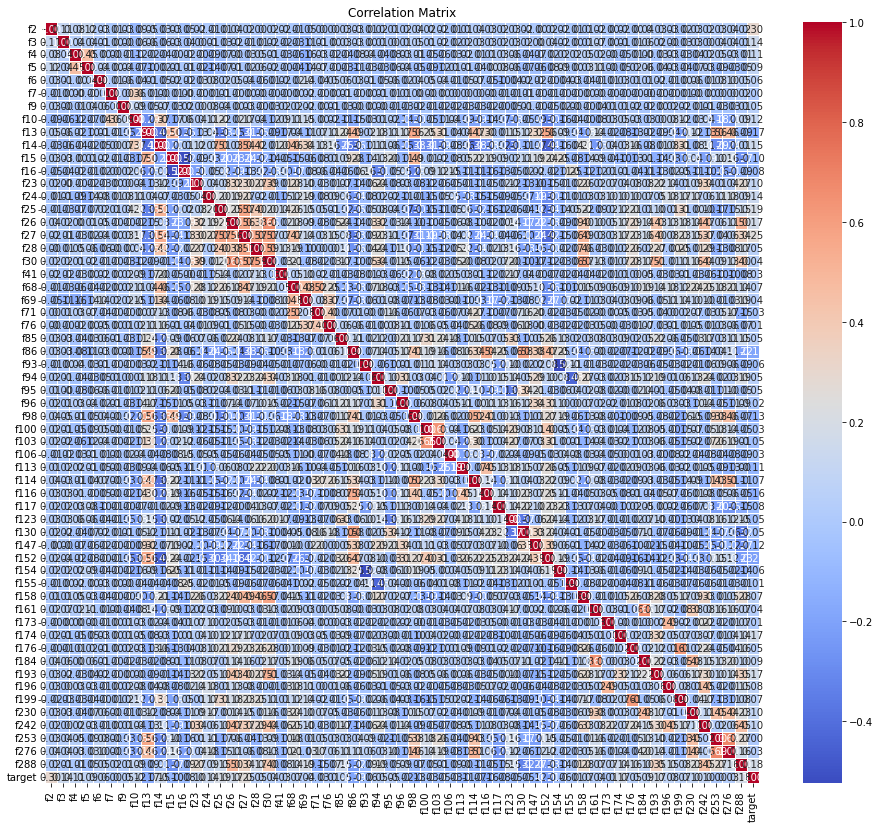

In [12]:
# Корреляционная матрица
correlation_matrix = train_data.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

Стало получше. Идём дальше

In [13]:
print(train_data.dtypes.tolist())

[dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('O'), dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('O'), dtype('float64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('O'), dtype('float64'), dtype('float64'), dtype('O'), dtype('float64'), dtype('float64'), dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('fl

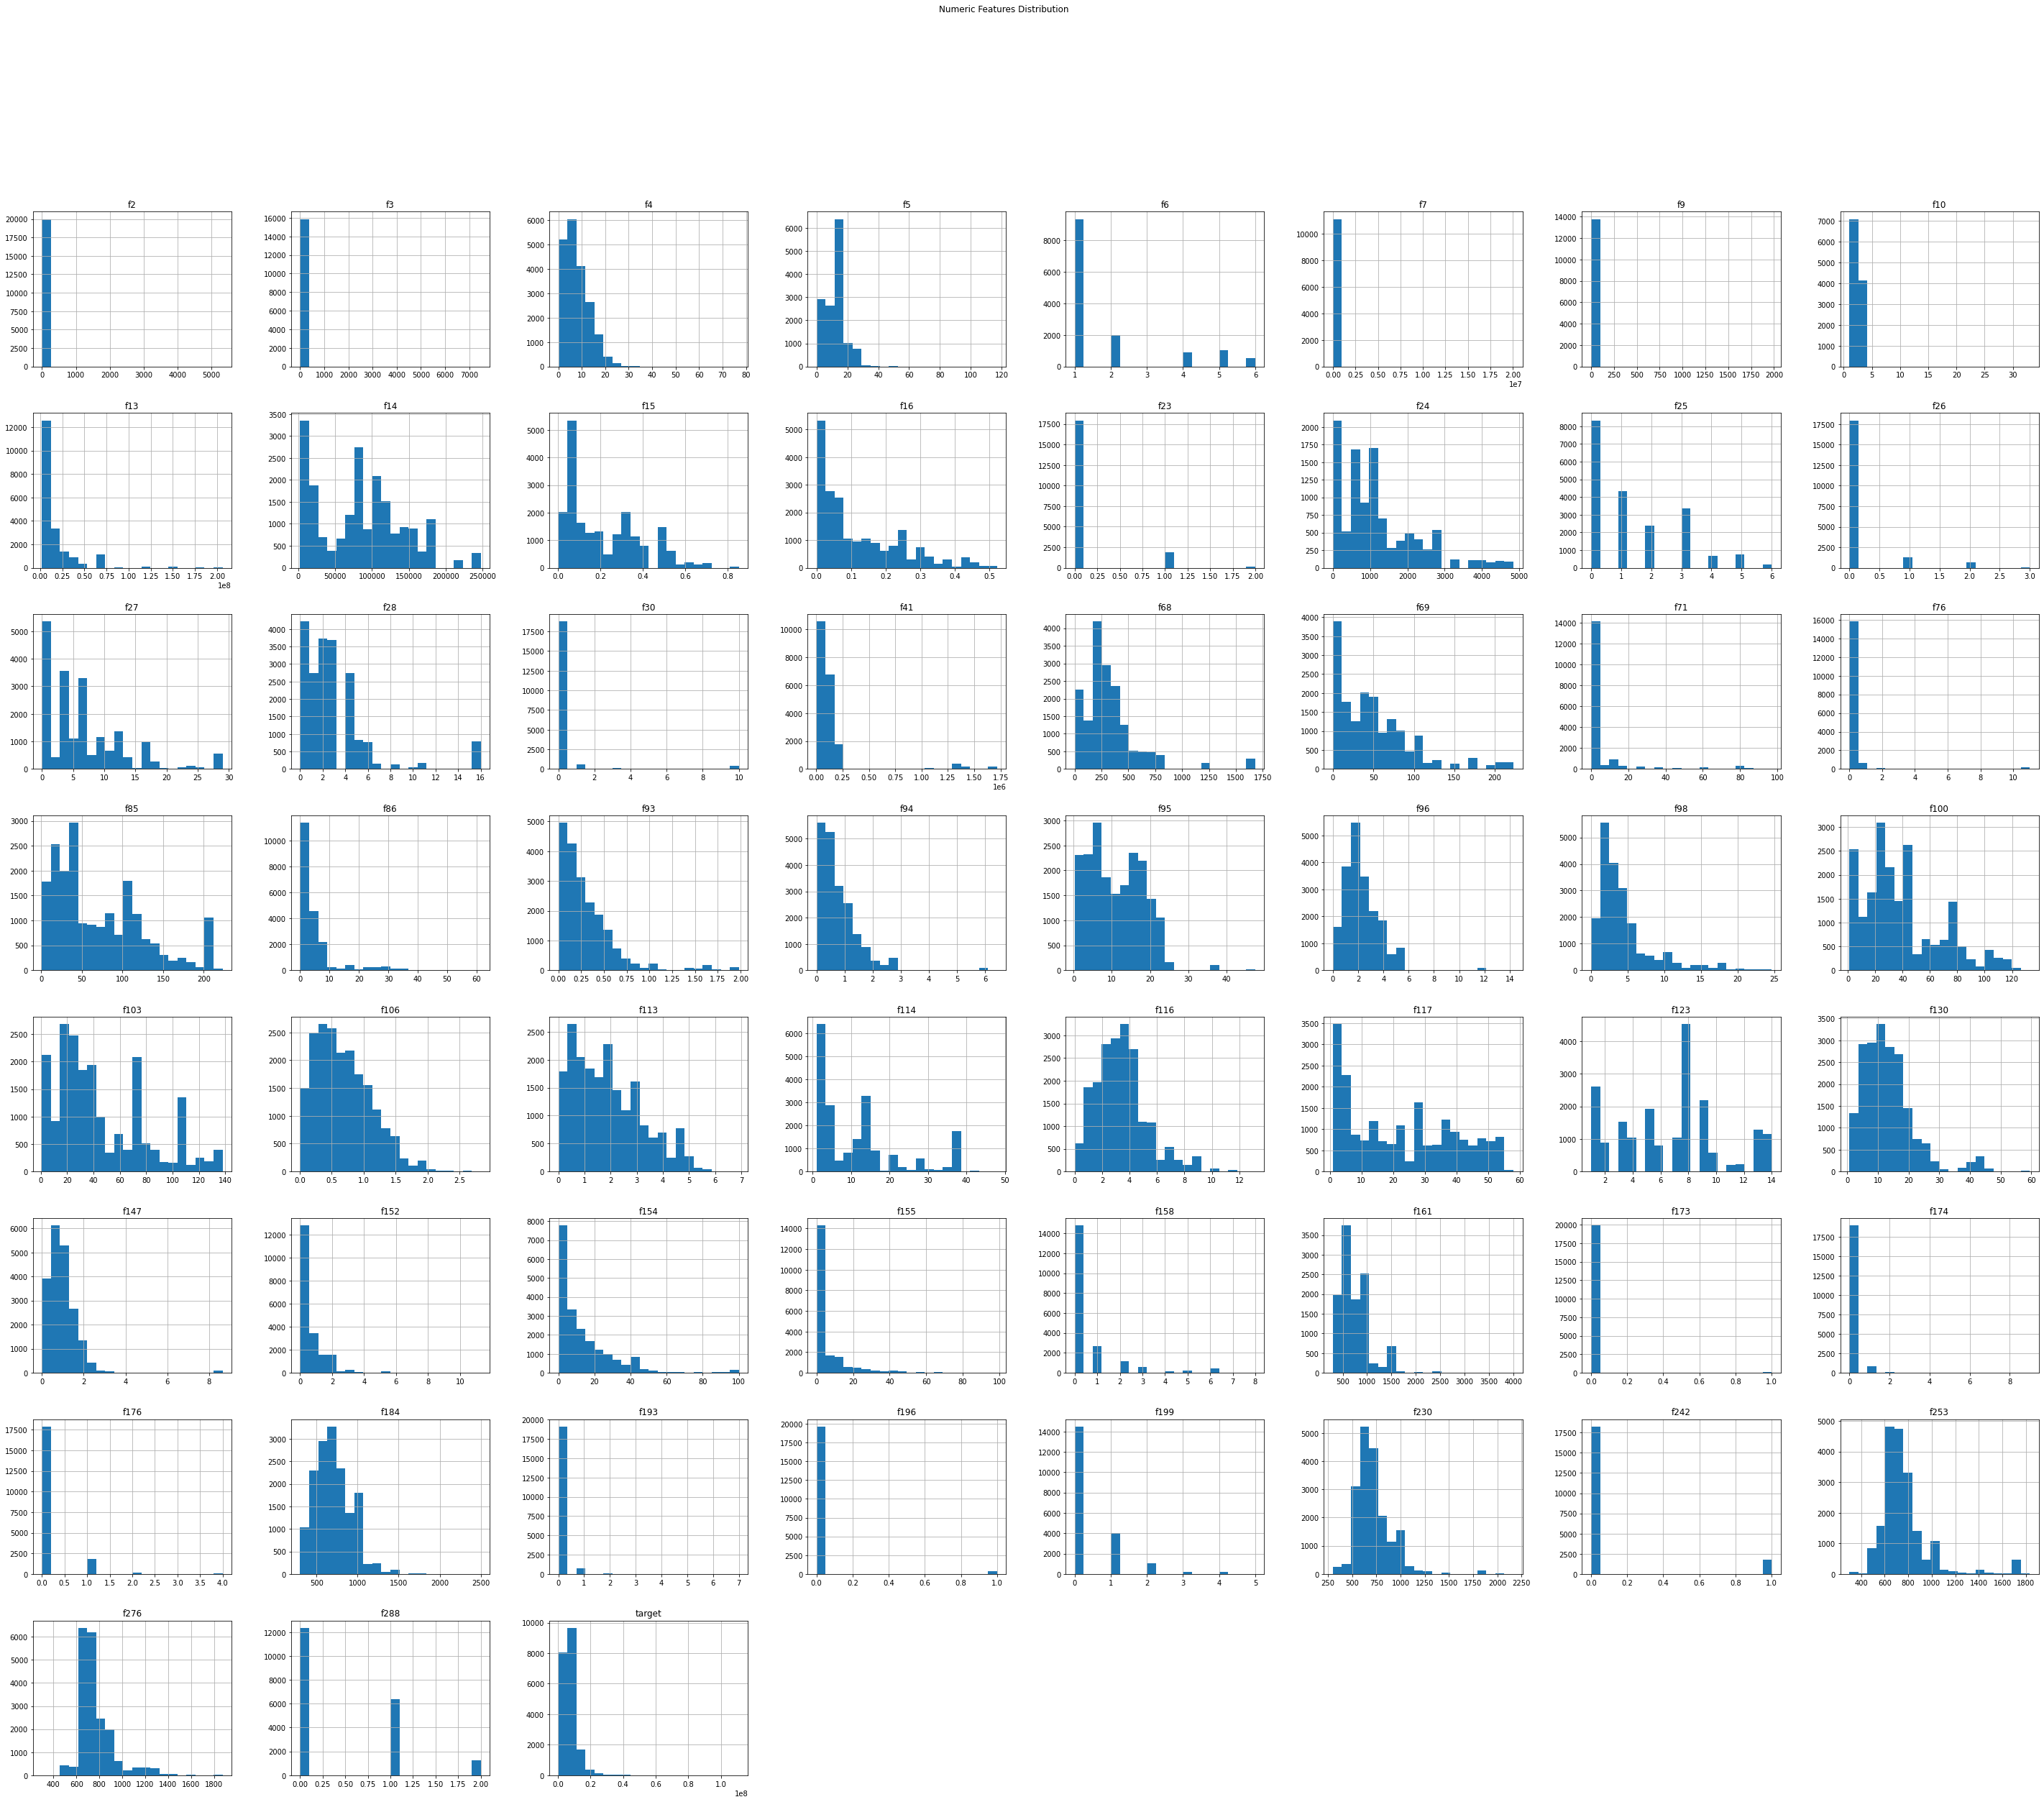

In [14]:
numeric_features = train_data.select_dtypes(include=['int64', 'float64']).columns
train_data[numeric_features].hist(figsize=(50, 40), bins=20)
plt.suptitle('Numeric Features Distribution')
plt.show()

In [15]:
categorical_columns = train_data.select_dtypes(include=['object']).columns

In [16]:
categorical_columns

Index(['f11', 'f12', 'f29', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39',
       'f40', 'f107', 'f115', 'f119', 'f153'],
      dtype='object')

In [17]:
train_data[categorical_columns]

,f11,f12,f29,f33,f34,f35,f36,f37,f38,f39,f40,f107,f115,f119,f153
0,Investment,Birjulevo Zapadnoe,no,yes,yes,no,yes,no,no,no,no,no,no,no,satisfactory
1,Investment,Tverskoe,yes,no,no,no,yes,yes,no,no,yes,no,no,no,poor
2,Investment,Beskudnikovskoe,no,no,no,no,no,no,no,no,no,no,no,no,poor
3,OwnerOccupier,Poselenie Sosenskoe,no,no,no,no,no,no,yes,no,no,no,no,no,no data
4,Investment,Ochakovo-Matveevskoe,no,yes,no,no,no,no,no,no,no,no,no,no,satisfactory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,Investment,Kuz'minki,no,no,no,no,yes,no,no,no,no,no,no,no,poor
19995,Investment,Gol'janovo,no,no,no,no,yes,no,no,no,no,no,no,no,good
19996,Investment,Severnoe Butovo,no,no,no,no,no,no,no,no,no,no,no,no,good
19997,Investment,Ochakovo-Matveevskoe,no,yes,no,no,no,no,no,no,no,no,no,no,satisfactory


In [18]:
train_data['f12'].nunique()

146

Кажется, что это объявления о продаже квартир или что-то подобное

Некоторые фичи в начале после просмотра тут

Для кат. фич где немного уник. значений будем использовать LabelEncoder, там где много - OneHotEncoder

In [19]:
def encode_categorical_features(train_data, max_unique_values):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

    # Определение фич с малым количеством уникальных значений
    columns_with_few_unique_values = [col for col in categorical_columns if train_data[col].nunique() <= max_unique_values]

    # с большим
    columns_with_many_unique_values = [col for col in categorical_columns if col not in columns_with_few_unique_values]

    # Применение LabelEncoder к фичам с малым количеством уникальных значений
    for column in columns_with_few_unique_values:
        train_data[column] = label_encoder.fit_transform(train_data[column])

    # Применение OneHotEncoder к фичам с большим количеством уникальных значений
    encoded_features = onehot_encoder.fit_transform(train_data[columns_with_many_unique_values])
    encoded_df = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names(columns_with_many_unique_values))

    # Объединение результатов кодирования обратно с исходным датафреймом
    data_encoded = pd.concat([train_data.drop(columns_with_many_unique_values, axis=1).reset_index(drop=True), encoded_df], axis=1)

    return data_encoded

In [20]:
train_data_encoded = encode_categorical_features(train_data, 10)

/home/yashamov/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
train_data_encoded

,f2,f3,f4,f5,f6,f7,f9,f10,f11,f13,...,f12_Vnukovo,f12_Vojkovskoe,f12_Vostochnoe,f12_Vostochnoe Degunino,f12_Vostochnoe Izmajlovo,f12_Vyhino-Zhulebino,f12_Zamoskvorech'e,f12_Zapadnoe Degunino,f12_Zjablikovo,f12_Zjuzino
0,37.0,19.0,5.0,16.0,1.0,1984.0,9.0,2.0,0,8.464344e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,53.0,30.0,10.0,12.0,1.0,1983.0,8.0,3.0,0,7.307411e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38.0,17.0,11.0,NaN,NaN,NaN,NaN,NaN,0,3.292112e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,75.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1,6.677245e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35.0,19.0,6.0,12.0,1.0,1971.0,10.0,3.0,0,1.752651e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,45.0,25.0,3.0,NaN,NaN,NaN,NaN,NaN,0,7.984444e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19995,48.0,30.0,3.0,5.0,1.0,1967.0,7.0,2.0,0,1.428699e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,52.0,30.0,11.0,NaN,NaN,NaN,NaN,NaN,0,8.889467e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,27.0,14.0,3.0,5.0,1.0,1966.0,5.0,3.0,0,1.752651e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Касательно многих фич есть вопросы. Проверим на важность

Дропнем строки с пропусками

In [22]:
train_data = train_data_encoded.dropna(axis=1)
X = train_data.drop('target', axis=1)
y = train_data['target']

In [23]:
train_data.shape

(19999, 200)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Стандартизируем 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
    }

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmsle = mean_squared_log_error(y_test, y_pred) ** 0.5  # RMSLE метрика
    return -rmsle

# Создание и оптимизация study
study = optuna.create_study(direction='maximize')  # Максимизация для минимизации отрицательной метрики
study.optimize(objective, n_trials=20)

[I 2023-12-18 18:30:53,677] A new study created in memory with name: no-name-3e90dbae-fed9-465a-870c-29fca1c4b2af


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:30:54,428] Trial 0 finished with value: -0.48832639229342384 and parameters: {'learning_rate': 0.020505940974103597, 'num_leaves': 86}. Best is trial 0 with value: -0.48832639229342384.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:30:55,437] Trial 1 finished with value: -0.4826346964418979 and parameters: {'learning_rate': 0.027016945489540117, 'num_leaves': 149}. Best is trial 1 with value: -0.4826346964418979.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:30:56,193] Trial 2 finished with value: -0.47903890883620703 and parameters: {'learning_rate': 0.041880266055130254, 'num_leaves': 107}. Best is trial 2 with value: -0.47903890883620703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:30:57,005] Trial 3 finished with value: -0.5606695761821668 and parameters: {'learning_rate': 0.0034881910659256715, 'num_leaves': 108}. Best is trial 2 with value: -0.47903890883620703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:30:57,327] Trial 4 finished with value: -0.4814081669821189 and parameters: {'learning_rate': 0.044865681060362726, 'num_leaves': 27}. Best is trial 2 with value: -0.47903890883620703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:30:57,691] Trial 5 finished with value: -0.5138694025515812 and parameters: {'learning_rate': 0.01145128912372374, 'num_leaves': 31}. Best is trial 2 with value: -0.47903890883620703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:30:58,083] Trial 6 finished with value: -0.4768332808133468 and parameters: {'learning_rate': 0.08786868223697472, 'num_leaves': 39}. Best is trial 6 with value: -0.4768332808133468.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:30:58,482] Trial 7 finished with value: -0.4768836550346612 and parameters: {'learning_rate': 0.09804509810907254, 'num_leaves': 37}. Best is trial 6 with value: -0.4768332808133468.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:30:59,441] Trial 8 finished with value: -0.5137693484680256 and parameters: {'learning_rate': 0.009211887118064626, 'num_leaves': 139}. Best is trial 6 with value: -0.4768332808133468.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:30:59,754] Trial 9 finished with value: -0.47731854388952605 and parameters: {'learning_rate': 0.09230030439293176, 'num_leaves': 28}. Best is trial 6 with value: -0.4768332808133468.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:31:00,330] Trial 10 finished with value: -0.47744768606072063 and parameters: {'learning_rate': 0.07419318046086786, 'num_leaves': 68}. Best is trial 6 with value: -0.4768332808133468.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:31:00,861] Trial 11 finished with value: -0.4763679727628513 and parameters: {'learning_rate': 0.0962834485097257, 'num_leaves': 60}. Best is trial 11 with value: -0.4763679727628513.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:31:01,383] Trial 12 finished with value: -0.4780262586545434 and parameters: {'learning_rate': 0.07347915043339485, 'num_leaves': 64}. Best is trial 11 with value: -0.4763679727628513.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:31:02,512] Trial 13 finished with value: -0.47947460806154074 and parameters: {'learning_rate': 0.07767638960716311, 'num_leaves': 186}. Best is trial 11 with value: -0.4763679727628513.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:31:03,051] Trial 14 finished with value: -0.4776009375711872 and parameters: {'learning_rate': 0.06273118296373825, 'num_leaves': 61}. Best is trial 11 with value: -0.4763679727628513.
[I 2023-12-18 18:31:03,299] Trial 15 finished with value: -0.4800440236733843 and parameters: {'learning_rate': 0.0866081749125997, 'num_leaves': 13}. Best is trial 11 with value: -0.4763679727628513.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:31:03,810] Trial 16 finished with value: -0.4790206829231906 and parameters: {'learning_rate': 0.06024424616243823, 'num_leaves': 52}. Best is trial 11 with value: -0.4763679727628513.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:31:04,718] Trial 17 finished with value: -0.47922532750083713 and parameters: {'learning_rate': 0.08421091536111203, 'num_leaves': 128}. Best is trial 11 with value: -0.4763679727628513.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:31:05,383] Trial 18 finished with value: -0.47719730520403214 and parameters: {'learning_rate': 0.09991340055934254, 'num_leaves': 89}. Best is trial 11 with value: -0.4763679727628513.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


[I 2023-12-18 18:31:06,059] Trial 19 finished with value: -0.4779077497303477 and parameters: {'learning_rate': 0.06362320744426381, 'num_leaves': 87}. Best is trial 11 with value: -0.4763679727628513.


In [26]:
# Получение лучших параметров
best_params = study.best_params
print(f"Best Parameters: {best_params}")

Best Parameters: {'learning_rate': 0.0962834485097257, 'num_leaves': 60}


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5168
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 185
[LightGBM] [Info] Start training from score 7115514.652603


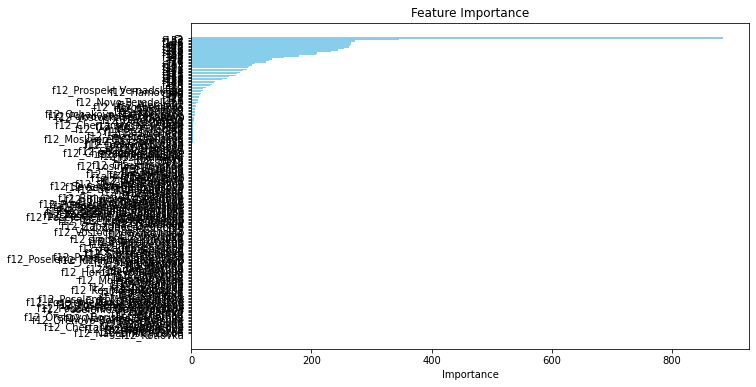

In [27]:
best_lgbm = LGBMRegressor(**best_params)
best_lgbm.fit(X_train, y_train)

# Оценка важности признаков
feature_importance = best_lgbm.feature_importances_
feature_names = X.columns

# Создание датафрейма с важностью признаков
feature_importance_df = pd.DataFrame(list(zip(feature_names, feature_importance)), columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# График важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [28]:
feature_importance_df[feature_importance_df['Importance'] > 30].shape

(33, 2)

In [29]:
feature_importance_df[feature_importance_df['Importance'] > 30]

,Feature,Importance
0,f2,884
40,f152,346
29,f106,272
39,f147,266
23,f86,266
24,f93,265
31,f113,263
27,f96,254
34,f116,244
25,f94,233


In [30]:
# Отберём самые важные фичи по результатам выше и моей субъективной оценки значимости. Район в теории тоже важен,
# но визуализация показала, что это не совсем правда

top_features = feature_importance_df['Feature'][:32]

# Создание нового датафрейма, включающего только выбранные фичи
selected_features_df = X[top_features]

In [31]:
selected_features_df

,f2,f152,f106,f147,f86,f93,f113,f96,f116,f94,...,f114,f13,f123,f155,f11,f158,f28,f153,f174,f288
0,37.0,0.206760,0.310148,1.427209,6.658569,0.280800,0.524126,2.221759,0.863735,0.972489,...,1.0,8.464344e+06,9.0,0.00,0,0.0,0.0,4,0.0,0.0
1,53.0,0.091026,1.017272,0.273968,2.566780,0.436176,0.652265,0.710639,0.652265,0.600421,...,34.0,7.307411e+06,5.0,0.00,0,0.0,16.0,3,0.0,1.0
2,38.0,0.311439,0.584052,0.337014,2.204105,0.325078,0.389536,2.086910,5.452492,0.388183,...,5.0,3.292112e+06,5.0,7.57,0,0.0,2.0,3,0.0,1.0
3,75.0,2.013040,1.957667,0.292257,6.422674,0.363252,2.489942,3.674100,2.969987,0.563742,...,1.0,6.677245e+07,9.0,0.00,1,0.0,0.0,2,0.0,1.0
4,35.0,1.021438,0.681776,1.344397,1.441212,0.033809,1.257531,0.755843,1.279731,0.476835,...,1.0,1.752651e+07,8.0,0.61,0,1.0,3.0,4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,45.0,0.237662,1.699036,1.093192,3.188467,0.540137,0.428651,1.692603,3.677939,0.713959,...,3.0,7.984444e+06,3.0,0.00,0,3.0,8.0,3,0.0,0.0
19995,48.0,0.451114,1.211930,1.070998,1.645464,0.947802,2.621621,1.636847,2.644912,0.311139,...,12.0,1.428699e+07,7.0,5.70,0,0.0,3.0,1,0.0,0.0
19996,52.0,0.383138,0.247749,0.578768,3.018901,0.185383,0.260030,0.436222,0.266372,0.918774,...,1.0,8.889467e+06,9.0,0.00,0,1.0,1.0,1,0.0,1.0
19997,27.0,0.586713,0.490651,0.784332,9.551507,0.077060,1.942028,4.133805,2.788718,2.164824,...,6.0,1.752651e+07,8.0,0.00,0,0.0,3.0,4,0.0,1.0


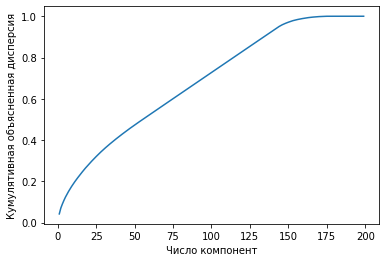

In [32]:
# Применим метод главных компонент к данным
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Получение объясненной дисперсии для каждой компоненты
explained_variance = pca.explained_variance_ratio_

# График объясненной дисперсии
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum())
plt.xlabel('Число компонент')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.show()

In [33]:
top_features = selected_features_df.columns

In [34]:
top_features

Index(['f2', 'f152', 'f106', 'f147', 'f86', 'f93', 'f113', 'f96', 'f116',
       'f94', 'f154', 'f85', 'f130', 'f95', 'f16', 'f14', 'f27', 'f15', 'f103',
       'f117', 'f193', 'f41', 'f114', 'f13', 'f123', 'f155', 'f11', 'f158',
       'f28', 'f153', 'f174', 'f288'],
      dtype='object')

## Теперь мы знаем какие фичи отбирать, можно построить модель смело

In [35]:
train_data = pd.read_csv('train.csv', sep = ';').drop(columns = ['id', 'f1', 'f75'])
test_data = pd.read_csv('test.csv', sep = ';').drop(columns = ['id', 'f1', 'f75'])

/tmp/ipykernel_8529/663960677.py:1: DtypeWarning: Columns (1,11,12,29,33,34,35,36,37,38,39,40,75,107,115,119,153) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train.csv', sep = ';').drop(columns = ['id', 'f1', 'f75'])


In [36]:
train_data.dropna(subset=['target'], inplace=True)

In [37]:
X = train_data.drop('target', axis=1)
y = train_data['target']

In [41]:
X_top_features = X[top_features]

In [45]:
X_top_features

,f2,f152,f106,f147,f86,f93,f113,f96,f116,f94,...,f114,f13,f123,f155,f11,f158,f28,f153,f174,f288
0,37.0,0.206760,0.310148,1.427209,6.658569,0.280800,0.524126,2.221759,0.863735,0.972489,...,1.0,8.464344e+06,9.0,0.00,Investment,0.0,0.0,satisfactory,0.0,0.0
1,53.0,0.091026,1.017272,0.273968,2.566780,0.436176,0.652265,0.710639,0.652265,0.600421,...,34.0,7.307411e+06,5.0,0.00,Investment,0.0,16.0,poor,0.0,1.0
2,38.0,0.311439,0.584052,0.337014,2.204105,0.325078,0.389536,2.086910,5.452492,0.388183,...,5.0,3.292112e+06,5.0,7.57,Investment,0.0,2.0,poor,0.0,1.0
3,75.0,2.013040,1.957667,0.292257,6.422674,0.363252,2.489942,3.674100,2.969987,0.563742,...,1.0,6.677245e+07,9.0,0.00,OwnerOccupier,0.0,0.0,no data,0.0,1.0
4,35.0,1.021438,0.681776,1.344397,1.441212,0.033809,1.257531,0.755843,1.279731,0.476835,...,1.0,1.752651e+07,8.0,0.61,Investment,1.0,3.0,satisfactory,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,45.0,0.237662,1.699036,1.093192,3.188467,0.540137,0.428651,1.692603,3.677939,0.713959,...,3.0,7.984444e+06,3.0,0.00,Investment,3.0,8.0,poor,0.0,0.0
19995,48.0,0.451114,1.211930,1.070998,1.645464,0.947802,2.621621,1.636847,2.644912,0.311139,...,12.0,1.428699e+07,7.0,5.70,Investment,0.0,3.0,good,0.0,0.0
19996,52.0,0.383138,0.247749,0.578768,3.018901,0.185383,0.260030,0.436222,0.266372,0.918774,...,1.0,8.889467e+06,9.0,0.00,Investment,1.0,1.0,good,0.0,1.0
19997,27.0,0.586713,0.490651,0.784332,9.551507,0.077060,1.942028,4.133805,2.788718,2.164824,...,6.0,1.752651e+07,8.0,0.00,Investment,0.0,3.0,satisfactory,0.0,1.0


In [46]:
categorical_columns = X_top_features.select_dtypes(include=['object']).columns

In [47]:
categorical_columns

Index(['f11', 'f153'], dtype='object')

In [48]:
X_top_features_encoded = encode_categorical_features(X_top_features, 10)
X_top_features_encoded

/tmp/ipykernel_8529/3579582302.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = label_encoder.fit_transform(train_data[column])
/home/yashamov/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,f2,f152,f106,f147,f86,f93,f113,f96,f116,f94,...,f114,f13,f123,f155,f11,f158,f28,f153,f174,f288
0,37.0,0.206760,0.310148,1.427209,6.658569,0.280800,0.524126,2.221759,0.863735,0.972489,...,1.0,8.464344e+06,9.0,0.00,0,0.0,0.0,4,0.0,0.0
1,53.0,0.091026,1.017272,0.273968,2.566780,0.436176,0.652265,0.710639,0.652265,0.600421,...,34.0,7.307411e+06,5.0,0.00,0,0.0,16.0,3,0.0,1.0
2,38.0,0.311439,0.584052,0.337014,2.204105,0.325078,0.389536,2.086910,5.452492,0.388183,...,5.0,3.292112e+06,5.0,7.57,0,0.0,2.0,3,0.0,1.0
3,75.0,2.013040,1.957667,0.292257,6.422674,0.363252,2.489942,3.674100,2.969987,0.563742,...,1.0,6.677245e+07,9.0,0.00,1,0.0,0.0,2,0.0,1.0
4,35.0,1.021438,0.681776,1.344397,1.441212,0.033809,1.257531,0.755843,1.279731,0.476835,...,1.0,1.752651e+07,8.0,0.61,0,1.0,3.0,4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,45.0,0.237662,1.699036,1.093192,3.188467,0.540137,0.428651,1.692603,3.677939,0.713959,...,3.0,7.984444e+06,3.0,0.00,0,3.0,8.0,3,0.0,0.0
19995,48.0,0.451114,1.211930,1.070998,1.645464,0.947802,2.621621,1.636847,2.644912,0.311139,...,12.0,1.428699e+07,7.0,5.70,0,0.0,3.0,1,0.0,0.0
19996,52.0,0.383138,0.247749,0.578768,3.018901,0.185383,0.260030,0.436222,0.266372,0.918774,...,1.0,8.889467e+06,9.0,0.00,0,1.0,1.0,1,0.0,1.0
19997,27.0,0.586713,0.490651,0.784332,9.551507,0.077060,1.942028,4.133805,2.788718,2.164824,...,6.0,1.752651e+07,8.0,0.00,0,0.0,3.0,4,0.0,1.0


In [49]:
# Сразу подкорректируем и тестовый цсв

test_data_top_features = test_data[top_features]
test_data_top_features_encoded = encode_categorical_features(test_data_top_features, 10)
test_data_top_features_encoded

/tmp/ipykernel_8529/3579582302.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = label_encoder.fit_transform(train_data[column])
/home/yashamov/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,f2,f152,f106,f147,f86,f93,f113,f96,f116,f94,...,f114,f13,f123,f155,f11,f158,f28,f153,f174,f288
0,41,0.243381,0.797115,2.233688,5.700928,0.391683,0.873596,2.043160,1.076896,0.287159,...,5,7.126815e+06,1,18.45,0,0,2,3,0,0
1,58,0.595717,1.460725,0.958004,1.936978,0.385230,1.144927,0.416939,1.178634,0.158664,...,21,1.509487e+07,3,13.75,0,1,11,3,1,0
2,35,0.404548,1.112507,1.564661,1.616185,0.252649,0.465802,3.021578,2.769229,0.627222,...,3,6.377883e+06,3,0.00,0,0,3,3,0,0
3,33,0.380602,0.822681,1.136499,3.885027,0.600092,0.873452,1.869057,1.371542,0.159746,...,9,1.686153e+07,1,23.55,0,1,2,4,0,0
4,53,0.228632,1.192991,0.695348,3.680493,0.228249,2.413686,2.485668,4.019218,0.498539,...,5,1.005305e+07,4,0.00,0,0,3,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4373,73,1.041306,0.771108,1.603546,6.238376,0.362677,3.472753,3.286658,3.532869,0.864273,...,1,1.880000e+07,8,0.00,1,0,5,4,0,2
4374,44,0.855493,0.888207,0.920709,8.233955,0.193457,1.444098,1.017887,4.585951,0.309300,...,38,6.677245e+07,9,1.51,1,0,0,2,0,1
4375,37,0.201954,0.768283,0.789242,2.364721,0.137925,0.861485,0.924834,3.687522,0.507716,...,1,3.707575e+06,3,0.00,0,1,0,1,0,0
4376,45,0.220098,1.245886,0.860638,1.553888,0.211521,2.208423,3.482760,2.392198,0.963493,...,33,5.235177e+07,1,0.00,0,2,2,1,0,0


In [50]:
# Обработка пропущенных значений, заполняем средними
imputer = SimpleImputer(strategy='mean')
X_top_features_encoded = pd.DataFrame(imputer.fit_transform(X_top_features_encoded), columns=X_top_features_encoded.columns)
test_data_top_features_encoded = pd.DataFrame(imputer.fit_transform(test_data_top_features_encoded), columns=test_data_top_features_encoded.columns)

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X_top_features_encoded, y, test_size=0.2, random_state=42)

# Стандартизируем
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

scaler1 = StandardScaler()
X_top_features_encoded = scaler1.fit_transform(X_top_features_encoded)
X_test = scaler1.transform(test_data_top_features_encoded)

In [52]:
#Снова подберём оптимальные параметры, только способом получше

def objective_lgbm(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 20, 100),
        'random_state': 42,
    }

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmsle = mean_squared_log_error(y_val, y_pred) ** 0.5
    return -rmsle  # Так как мы максимизируем, а оптимизатор Optuna минимизирует

study_lgbm = optuna.create_study(direction='maximize', study_name="LGBM Regression")
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2023-12-18 18:34:13,683] A new study created in memory with name: LGBM Regression


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8980464966864686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8980464966864686
[LightGBM] [Warning] bagging_fraction is set=0.49897565607638195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49897565607638195
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8980464966864686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8980464966864686
[LightGBM] [Warning] bagging_fraction is set=0.49897565607638195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49897565607638195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memor

[I 2023-12-18 18:34:13,962] Trial 0 finished with value: -0.4793630111434197 and parameters: {'num_leaves': 61, 'learning_rate': 0.04834568128516159, 'feature_fraction': 0.8980464966864686, 'bagging_fraction': 0.49897565607638195, 'bagging_freq': 10, 'n_estimators': 100}. Best is trial 0 with value: -0.4793630111434197.


[LightGBM] [Warning] feature_fraction is set=0.8980464966864686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8980464966864686
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.49897565607638195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49897565607638195
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5507311905056599, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5507311905056599
[LightGBM] [Warning] bagging_fraction is set=0.1967011233208002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1967011233208002
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5507311905056599, colsa

[I 2023-12-18 18:34:14,222] Trial 1 finished with value: -0.48334215176724515 and parameters: {'num_leaves': 148, 'learning_rate': 0.07399247201474131, 'feature_fraction': 0.5507311905056599, 'bagging_fraction': 0.1967011233208002, 'bagging_freq': 5, 'n_estimators': 76}. Best is trial 0 with value: -0.4793630111434197.
[I 2023-12-18 18:34:14,335] Trial 2 finished with value: -0.5279306038002207 and parameters: {'num_leaves': 41, 'learning_rate': 0.034082893459521944, 'feature_fraction': 0.15973039860672125, 'bagging_fraction': 0.35354164052096526, 'bagging_freq': 7, 'n_estimators': 62}. Best is trial 0 with value: -0.4793630111434197.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-12-18 18:34:14,491] Trial 3 finished with value: -0.5023412610772093 and parameters: {'num_leaves': 50, 'learning_rate': 0.020164779132342332, 'feature_fraction': 0.2563032717262933, 'bagging_fraction': 0.599471883025966, 'bagging_freq': 9, 'n_estimators': 82}. Best is trial 0 with value: -0.4793630111434197.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.2563032717262933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2563032717262933
[LightGBM] [Warning] bagging_fraction is set=0.599471883025966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.599471883025966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4690
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 32
[LightGBM] [Info] Start training from score 7115514.652603
[LightGBM] [Warning] feature_fraction is set=0.2563032717262933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2563032717262933
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value

[I 2023-12-18 18:34:14,663] Trial 4 finished with value: -0.48534337049689197 and parameters: {'num_leaves': 177, 'learning_rate': 0.07081469564203191, 'feature_fraction': 0.7261380834308487, 'bagging_fraction': 0.2648326200648278, 'bagging_freq': 10, 'n_estimators': 38}. Best is trial 0 with value: -0.4793630111434197.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-12-18 18:34:14,812] Trial 5 finished with value: -0.4850310001704997 and parameters: {'num_leaves': 41, 'learning_rate': 0.0902373510116164, 'feature_fraction': 0.5118279505521857, 'bagging_fraction': 0.20371844652757443, 'bagging_freq': 9, 'n_estimators': 78}. Best is trial 0 with value: -0.4793630111434197.


[LightGBM] [Warning] feature_fraction is set=0.5118279505521857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5118279505521857
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.20371844652757443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20371844652757443
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.27139692976174107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27139692976174107
[LightGBM] [Warning] bagging_fraction is set=0.45673558728115726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45673558728115726
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.27139692976174107, co

[I 2023-12-18 18:34:15,104] Trial 6 finished with value: -0.49456332323397084 and parameters: {'num_leaves': 233, 'learning_rate': 0.06055874925153037, 'feature_fraction': 0.27139692976174107, 'bagging_fraction': 0.45673558728115726, 'bagging_freq': 4, 'n_estimators': 59}. Best is trial 0 with value: -0.4793630111434197.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.27139692976174107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27139692976174107
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.45673558728115726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45673558728115726
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.732659955913487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.732659955913487
[LightGBM] [Warning] bagging_fraction is set=0.20778113418129623, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20778113418129623
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_fr

[I 2023-12-18 18:34:15,359] Trial 7 finished with value: -0.4845278541674087 and parameters: {'num_leaves': 193, 'learning_rate': 0.06531837336188594, 'feature_fraction': 0.732659955913487, 'bagging_fraction': 0.20778113418129623, 'bagging_freq': 8, 'n_estimators': 61}. Best is trial 0 with value: -0.4793630111434197.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-12-18 18:34:15,621] Trial 8 finished with value: -0.48129509677417215 and parameters: {'num_leaves': 187, 'learning_rate': 0.04797615436886931, 'feature_fraction': 0.7948087544965857, 'bagging_fraction': 0.21844129740395213, 'bagging_freq': 8, 'n_estimators': 79}. Best is trial 0 with value: -0.4793630111434197.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-12-18 18:34:15,798] Trial 9 finished with value: -0.4815338347457494 and parameters: {'num_leaves': 76, 'learning_rate': 0.08486813844895652, 'feature_fraction': 0.5999415265814086, 'bagging_fraction': 0.6621482327030568, 'bagging_freq': 8, 'n_estimators': 49}. Best is trial 0 with value: -0.4793630111434197.


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5999415265814086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5999415265814086
[LightGBM] [Warning] bagging_fraction is set=0.6621482327030568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6621482327030568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4690
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 32
[LightGBM] [Info] Start training from score 7115514.652603
[LightGBM] [Warning] feature_fraction is set=0.5999415265814086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5999415265814086
[LightGBM] [Warning] bagg

[I 2023-12-18 18:34:16,220] Trial 10 finished with value: -0.5765113261817567 and parameters: {'num_leaves': 102, 'learning_rate': 0.002495081762812615, 'feature_fraction': 0.9380524470257614, 'bagging_fraction': 0.9152734607663516, 'bagging_freq': 1, 'n_estimators': 98}. Best is trial 0 with value: -0.4793630111434197.
[I 2023-12-18 18:34:16,312] Trial 11 finished with value: -0.5091719013716991 and parameters: {'num_leaves': 3, 'learning_rate': 0.04141606491640763, 'feature_fraction': 0.9639049883260677, 'bagging_fraction': 0.7610851749787322, 'bagging_freq': 10, 'n_estimators': 98}. Best is trial 0 with value: -0.4793630111434197.


[LightGBM] [Warning] feature_fraction is set=0.9380524470257614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9380524470257614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9152734607663516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9152734607663516
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9639049883260677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9639049883260677
[LightGBM] [Warning] bagging_fraction is set=0.7610851749787322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7610851749787322
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9639049883260677, colsa

[I 2023-12-18 18:34:16,890] Trial 12 finished with value: -0.47917364771307713 and parameters: {'num_leaves': 255, 'learning_rate': 0.04661587993904756, 'feature_fraction': 0.7999663237835405, 'bagging_fraction': 0.44367307616673907, 'bagging_freq': 6, 'n_estimators': 88}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] feature_fraction is set=0.7999663237835405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999663237835405
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.44367307616673907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44367307616673907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8348238945269315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8348238945269315
[LightGBM] [Warning] bagging_fraction is set=0.4568807034899081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4568807034899081
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8348238945269315, colsamp

[I 2023-12-18 18:34:17,304] Trial 13 finished with value: -0.4808581506981192 and parameters: {'num_leaves': 120, 'learning_rate': 0.029609295553469438, 'feature_fraction': 0.8348238945269315, 'bagging_fraction': 0.4568807034899081, 'bagging_freq': 3, 'n_estimators': 100}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] feature_fraction is set=0.8348238945269315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8348238945269315
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.4568807034899081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4568807034899081
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8859813626659413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8859813626659413
[LightGBM] [Warning] bagging_fraction is set=0.46684284288857014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46684284288857014
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8859813626659413, colsamp

[I 2023-12-18 18:34:17,877] Trial 14 finished with value: -0.48208364474901644 and parameters: {'num_leaves': 250, 'learning_rate': 0.0562262672286236, 'feature_fraction': 0.8859813626659413, 'bagging_fraction': 0.46684284288857014, 'bagging_freq': 6, 'n_estimators': 89}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.8859813626659413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8859813626659413
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.46684284288857014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46684284288857014
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9959002910547033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9959002910547033
[LightGBM] [Warning] bagging_fraction is set=0.740917543709965, subsample=1.0 will be ignored. Current

[I 2023-12-18 18:34:18,060] Trial 15 finished with value: -0.5637561526345841 and parameters: {'num_leaves': 154, 'learning_rate': 0.015657648038155475, 'feature_fraction': 0.9959002910547033, 'bagging_fraction': 0.740917543709965, 'bagging_freq': 2, 'n_estimators': 20}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9959002910547033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9959002910547033
[LightGBM] [Warning] bagging_fraction is set=0.740917543709965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740917543709965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4690
[LightGBM] [Info] Number of data points in the train set: 15999, number of used features: 32
[LightGBM] [Info] Start training from score 7115514.652603
[LightGBM] [Warning] feature_fraction is set=0.9959002910547033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9959002910547033
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value

[I 2023-12-18 18:34:18,401] Trial 16 finished with value: -0.48191466930790455 and parameters: {'num_leaves': 89, 'learning_rate': 0.040873008253723773, 'feature_fraction': 0.6818798710913174, 'bagging_fraction': 0.3585992976879301, 'bagging_freq': 6, 'n_estimators': 90}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] feature_fraction is set=0.6818798710913174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6818798710913174
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.3585992976879301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3585992976879301
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4245775981584253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4245775981584253
[LightGBM] [Warning] bagging_fraction is set=0.5523750565556715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5523750565556715
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4245775981584253, colsample

[I 2023-12-18 18:34:18,834] Trial 17 finished with value: -0.4865601662717076 and parameters: {'num_leaves': 218, 'learning_rate': 0.099501711690933, 'feature_fraction': 0.4245775981584253, 'bagging_fraction': 0.5523750565556715, 'bagging_freq': 5, 'n_estimators': 70}. Best is trial 12 with value: -0.47917364771307713.
[I 2023-12-18 18:34:18,955] Trial 18 finished with value: -0.49489263925599986 and parameters: {'num_leaves': 8, 'learning_rate': 0.05261931013913413, 'feature_fraction': 0.8360705558377277, 'bagging_fraction': 0.9659282259419295, 'bagging_freq': 4, 'n_estimators': 70}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] feature_fraction is set=0.4245775981584253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4245775981584253
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5523750565556715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5523750565556715
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8360705558377277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8360705558377277
[LightGBM] [Warning] bagging_fraction is set=0.9659282259419295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9659282259419295
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8360705558377277, colsample

[I 2023-12-18 18:34:19,216] Trial 19 finished with value: -0.4909390829091078 and parameters: {'num_leaves': 72, 'learning_rate': 0.02344810021420183, 'feature_fraction': 0.6463509379735448, 'bagging_fraction': 0.39677940042784043, 'bagging_freq': 7, 'n_estimators': 89}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] feature_fraction is set=0.6463509379735448, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6463509379735448
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.39677940042784043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39677940042784043
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.44969899365495347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44969899365495347
[LightGBM] [Warning] bagging_fraction is set=0.663600386447335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.663600386447335
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.44969899365495347, colsam

[I 2023-12-18 18:34:19,559] Trial 20 finished with value: -0.48501726631860714 and parameters: {'num_leaves': 124, 'learning_rate': 0.044949908482287526, 'feature_fraction': 0.44969899365495347, 'bagging_fraction': 0.663600386447335, 'bagging_freq': 7, 'n_estimators': 90}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] feature_fraction is set=0.44969899365495347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44969899365495347
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.663600386447335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.663600386447335
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.812287019757691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.812287019757691
[LightGBM] [Warning] bagging_fraction is set=0.4760132723682326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4760132723682326
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.812287019757691, colsample_by

[I 2023-12-18 18:34:19,972] Trial 21 finished with value: -0.48102229033775645 and parameters: {'num_leaves': 120, 'learning_rate': 0.03048238629631931, 'feature_fraction': 0.812287019757691, 'bagging_fraction': 0.4760132723682326, 'bagging_freq': 3, 'n_estimators': 99}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] feature_fraction is set=0.812287019757691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.812287019757691
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.4760132723682326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4760132723682326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8665533632229709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8665533632229709
[LightGBM] [Warning] bagging_fraction is set=0.31698799703982805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31698799703982805
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8665533632229709, colsample

[I 2023-12-18 18:34:20,478] Trial 22 finished with value: -0.48097563256454423 and parameters: {'num_leaves': 153, 'learning_rate': 0.03329358722375307, 'feature_fraction': 0.8665533632229709, 'bagging_fraction': 0.31698799703982805, 'bagging_freq': 1, 'n_estimators': 100}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] feature_fraction is set=0.8665533632229709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8665533632229709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.31698799703982805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31698799703982805
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7658083051061191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7658083051061191
[LightGBM] [Warning] bagging_fraction is set=0.5162156057496831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162156057496831
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7658083051061191, colsamp

[I 2023-12-18 18:34:20,824] Trial 23 finished with value: -0.5292347231204706 and parameters: {'num_leaves': 107, 'learning_rate': 0.00792170630693572, 'feature_fraction': 0.7658083051061191, 'bagging_fraction': 0.5162156057496831, 'bagging_freq': 3, 'n_estimators': 92}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] feature_fraction is set=0.7658083051061191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7658083051061191
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5162156057496831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5162156057496831
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8757383625191282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757383625191282
[LightGBM] [Warning] bagging_fraction is set=0.41603600287658465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41603600287658465
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8757383625191282, colsamp

[I 2023-12-18 18:34:21,287] Trial 24 finished with value: -0.4838987837427316 and parameters: {'num_leaves': 205, 'learning_rate': 0.026895860709460182, 'feature_fraction': 0.8757383625191282, 'bagging_fraction': 0.41603600287658465, 'bagging_freq': 3, 'n_estimators': 85}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] feature_fraction is set=0.8757383625191282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8757383625191282
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.41603600287658465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41603600287658465
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9376939177394777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9376939177394777
[LightGBM] [Warning] bagging_fraction is set=0.5962264629143973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5962264629143973
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9376939177394777, colsamp

[I 2023-12-18 18:34:21,579] Trial 25 finished with value: -0.48095966880956287 and parameters: {'num_leaves': 64, 'learning_rate': 0.03787272879777731, 'feature_fraction': 0.9376939177394777, 'bagging_fraction': 0.5962264629143973, 'bagging_freq': 4, 'n_estimators': 95}. Best is trial 12 with value: -0.47917364771307713.
[I 2023-12-18 18:34:21,708] Trial 26 finished with value: -0.4851288573153471 and parameters: {'num_leaves': 27, 'learning_rate': 0.052781781392186526, 'feature_fraction': 0.6669264469917092, 'bagging_fraction': 0.31445635315722176, 'bagging_freq': 2, 'n_estimators': 72}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] feature_fraction is set=0.9376939177394777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9376939177394777
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5962264629143973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5962264629143973
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6669264469917092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6669264469917092
[LightGBM] [Warning] bagging_fraction is set=0.31445635315722176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31445635315722176
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6669264469917092, colsamp

[I 2023-12-18 18:34:22,209] Trial 27 finished with value: -0.4968825960384314 and parameters: {'num_leaves': 165, 'learning_rate': 0.016918515862961628, 'feature_fraction': 0.9229244651126205, 'bagging_fraction': 0.539335410964521, 'bagging_freq': 5, 'n_estimators': 82}. Best is trial 12 with value: -0.47917364771307713.


[LightGBM] [Warning] feature_fraction is set=0.9229244651126205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9229244651126205
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.539335410964521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.539335410964521
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7763822372190746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7763822372190746
[LightGBM] [Warning] bagging_fraction is set=0.812436871632565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.812436871632565
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7763822372190746, colsample_byt

[I 2023-12-18 18:34:22,697] Trial 28 finished with value: -0.477822405975676 and parameters: {'num_leaves': 131, 'learning_rate': 0.05968351817156536, 'feature_fraction': 0.7763822372190746, 'bagging_fraction': 0.812436871632565, 'bagging_freq': 2, 'n_estimators': 86}. Best is trial 28 with value: -0.477822405975676.


[LightGBM] [Warning] feature_fraction is set=0.7763822372190746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7763822372190746
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.812436871632565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.812436871632565
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6166082774706882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6166082774706882
[LightGBM] [Warning] bagging_fraction is set=0.10674399609024171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10674399609024171
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6166082774706882, colsample

[I 2023-12-18 18:34:22,897] Trial 29 finished with value: -0.4906487147370914 and parameters: {'num_leaves': 250, 'learning_rate': 0.07815518559364348, 'feature_fraction': 0.6166082774706882, 'bagging_fraction': 0.10674399609024171, 'bagging_freq': 9, 'n_estimators': 73}. Best is trial 28 with value: -0.477822405975676.


In [53]:
best_params = study_lgbm.best_params
best_rmsle = study_lgbm.best_value
print(f"Лучшая RMSLE: {best_rmsle}")
print("Best Hyperparameters:", best_params)

Лучшая RMSLE: -0.477822405975676
Best Hyperparameters: {'num_leaves': 131, 'learning_rate': 0.05968351817156536, 'feature_fraction': 0.7763822372190746, 'bagging_fraction': 0.812436871632565, 'bagging_freq': 2, 'n_estimators': 86}


Ну и теперь обучимся полностью на нашем train.csv с предсказанием test.csv (на выбранных нами фичах)

In [54]:
model = LGBMRegressor(**best_params)
model.fit(X_top_features_encoded, y)
y_pred = model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.7763822372190746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7763822372190746
[LightGBM] [Warning] bagging_fraction is set=0.812436871632565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.812436871632565
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7763822372190746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7763822372190746
[LightGBM] [Warning] bagging_fraction is set=0.812436871632565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.812436871632565
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

In [55]:
submission = pd.DataFrame()

test = pd.read_csv('test.csv', sep = ';',index_col=False)
test_ID = test['id']

submission['id'] = test_ID
submission['prediction'] = y_pred
submission.to_csv('final_submission.csv',index=False)

In [56]:
submission

,id,prediction
0,19999,4.892563e+06
1,20000,7.088828e+06
2,20001,5.959077e+06
3,20002,4.706148e+06
4,20003,6.812708e+06
...,...,...
4373,24372,1.280138e+07
4374,24373,5.215726e+06
4375,24374,5.574183e+06
4376,24375,7.428956e+06


In [57]:
# На кагле получилось 0.464144